# Time Series Analysis

Understanding `scan` and effect handlers will help us understand the examples in the numpyro docs and to build our own Bayesian time series models with `numpyro` without relying on `for` loops.

In this notebook I start with a simple gaussian random walk model and then move to a Local Level model, then exponential smoothing to showcase time series forecasting models from scratch with `numpyro` and an emphasis on understanding some of the ins and outs of `numpyro`.

## Gaussian Random Walk

For our first model, we can simply take our trivial example of a gaussian random walk and use `numpyro` to infer hidden parameters.

The model would look something like:

$$
\begin{aligned}
y_t &= \mu_t\\
\mu_{t+1} &= \mu_t + \epsilon_\mu, \quad \epsilon_\mu \sim \mathcal{N}(0, \sigma_\mu)\\
\sigma_\mu &\sim \text{HalfCauchy}(1)
\end{aligned}
$$

or equivalently:

$$
\begin{aligned}
y_t &= \mu_t \\
\mu_{t+1} &\sim \mathcal{N}(\mu_t, \sigma_\mu)\\
\sigma_\mu &\sim \text{HalfCauchy}(1)
\end{aligned}
$$

This will give us a chance to use `scan` again within a `numpyro` model so that we can use the 'inference engine' to infer the distribution of the hidden parameters $\sigma_y$ from the data.


In [3]:
# Import required libraries
import numpyro 
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import matplotlib.pyplot as plt
import arviz as az

Simulate data from a gaussian random walk where the true $\sigma=1$ and initial $\mu_0=0$.

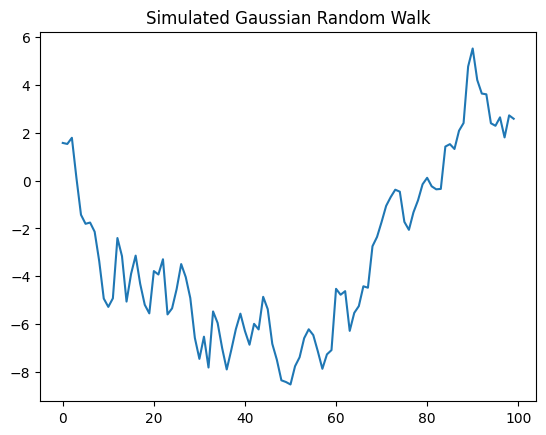

In [10]:
# Import libraries
from jax import random
import jax.numpy as jnp
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist

# Define our random walk function as an input into `scan`
def random_walk(value, x):    
    value = numpyro.sample('x', dist.Normal(value, 1.))
    # Which is the same as if we were very explicit:
    # value = value + numpyro.sample('x', dist.Normal(0, 1.))
    return value, value

init_0 = 0
T = jnp.arange(100)

# Need the `seed` effect handler in a context manager because of
# the need for a PRNG key within `numpyro.sample`
with numpyro.handlers.seed(rng_seed=42):
    final_location, locations = scan(random_walk, init=init_0, xs=T)

plt.plot(T, locations)
plt.title('Simulated Gaussian Random Walk');

Next we'll create a `numpyro` model for this gaussian random walk and render the graph with `numpyro.render_model`:

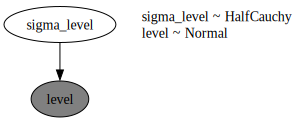

In [12]:
# gaussian random walk model

def random_walk_model(y):
    # Unknown Parameter
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))

    def transition_fn(level_t, t):
        new_level = numpyro.sample("level", dist.Normal(level_t, sigma_level)) # observed
        return new_level, None
    
    n_steps = y.shape[0]
    T = jnp.arange(1, n_steps) # because first value in the array is the init

    # Note the new handler here - we don't need the seed handler, but now we need to condition 
    # a variable on data to specify that it's observed
    with numpyro.handlers.condition(data={"level": y[1:]}):
        state, final_result = scan(transition_fn, init=y[0], xs=T)

# Render the model 
numpyro.render_model(random_walk_model, model_args=(locations,), render_distributions=True)

Note we added a `condition` handler so that we treat the `level` random variable $\mu_t$ as 'observed' and the only parameter we are concerned with is the `sigma_level` or $\sigma_\mu$ value in our gaussian random walk.

We then can use `numpyro`'s MCMC inference engine to sample from the posterior and retrieve the distribution of `sigma_level`.

In [46]:
# Inference
def run_inference(model, prng_key, **kwargs):
    mcmc = MCMC(sampler=NUTS(model), 
                num_samples=2000, 
                num_warmup=2000)
    mcmc.run(prng_key, **kwargs)
    return mcmc

prng_key = random.PRNGKey(123)
mcmc = run_inference(random_walk_model, prng_key, y=locations)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3411.70it/s, 3 steps of size 8.55e-01. acc. prob=0.95]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_level      0.98      0.07      0.98      0.88      1.10    725.91      1.00

Number of divergences: 0


We see that we can recover the unknown $\sigma$ from the random walk.

> **Note**: Plotting this stuff doesn't do us any good because we the time series itself is treated as 'observed' - so prior predictive and posterior predictive doesn't work as you would expect. Instead, what you *can* do is try to do a 1-step ahead forecast if we need to plot something...which I'll add in later.

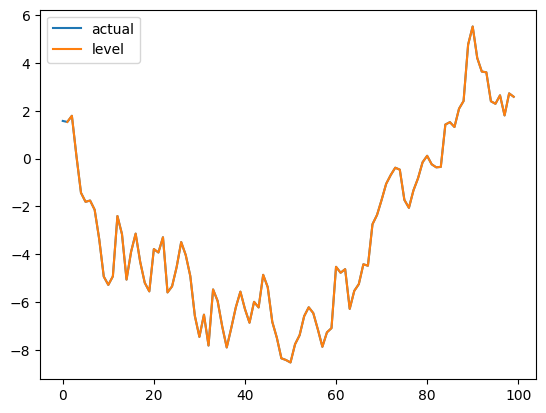

In [14]:
# What happens if you plot the prior predictive and the observed data?
rng_key1, rng_key2 = random.split(prng_key)
# Prior Predictive
prior_predictive = Predictive(random_walk_model, num_samples=100)
prior_predictive_samples = prior_predictive(rng_key2, locations)

# prior_mean_mu = prior_predictive_samples['mu'].mean(axis=0)
prior_mean_level = prior_predictive_samples['level'].mean(axis=0)

plt.plot(locations, label='actual')
plt.plot(jnp.arange(1, locations.shape[0]), prior_mean_level, label='level')
plt.legend()

## Local Level Model

Our next step on our journey takes us into the Local Level model, which is much like our Random Walk but we now add in a new parameter for observation noise.

Here is our familiar state space form of the model, now with the observation error $\epsilon_y$ added:

$$
\begin{aligned}
y_t &= \mu_t + \epsilon_y, \quad \epsilon_y \sim \mathcal{N}(0, \sigma_y)\\
\mu_{t+1} &= \mu_t + \epsilon_\mu, \quad \epsilon_\mu \sim \mathcal{N}(0, \sigma_\mu)
\end{aligned}
$$

Or, more succinctly:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma^2_y)\\
\mu_{t+1} &\sim \mathcal{N}(\mu_t, \sigma^2_\mu)\\
\sigma^2_y, \sigma^2_\mu &\sim \text{HalfCauchy}(1)
\end{aligned}
$$

We also set the initial level $\mu_0$ as an unknown parameter to be estimated.

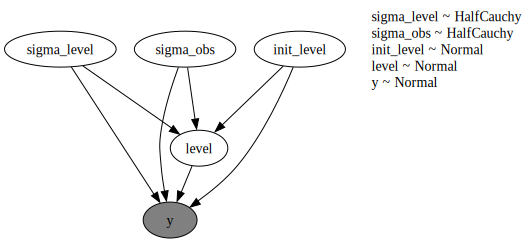

In [15]:
# local level model

def local_level(y):

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    level_0 = numpyro.sample("init_level", dist.Normal(y[0], 1))

    def transition_fn(carry, t):
        level_t = carry
        new_level = numpyro.sample("level", dist.Normal(level_t, sigma_level))
        new_obs = numpyro.sample("y", dist.Normal(new_level, sigma_obs)) # observed
        return new_level, None
    
    n_steps = y.shape[0]
    T = jnp.arange(1, n_steps) # because first value in the array is the init

    with numpyro.handlers.condition(data={"y": y[1:]}):
        state, final_result = scan(transition_fn, init=level_0, xs=T)

numpyro.render_model(local_level, model_args=(locations,), render_distributions=True)

If we look closely at the rendered graph, there's no indication that we're estimating a different `level` or $\mu_t$ value at each time step $t$, but this is partly a limitation with using the automated `numpyro.render_model` method (which is a wrapper around `graphviz`) and because we can't combing plate notation with `scan` in `numpyro` right now. If we really wanted to get fancy we'd wind up having to use tikz or something, but this is good enough for a single line of code!

In [16]:
# Inference
mcmc = run_inference(local_level, prng_key, y=locations)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2053.71it/s, 15 steps of size 1.46e-01. acc. prob=0.72]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   init_level      1.61      0.69      1.65      0.39      2.71    366.87      1.00
     level[0]      1.54      0.15      1.54      1.28      1.79   3152.05      1.00
     level[1]      1.74      0.17      1.77      1.47      1.97    211.55      1.00
     level[2]      0.11      0.16      0.11     -0.12      0.42   3127.58      1.00
     level[3]     -1.40      0.16     -1.42     -1.67     -1.17    529.55      1.00
     level[4]     -1.79      0.15     -1.80     -2.08     -1.58   2339.47      1.00
     level[5]     -1.77      0.14     -1.76     -1.99     -1.53   2956.07      1.00
     level[6]     -2.16      0.15     -2.15     -2.40     -1.92   1283.25      1.00
     level[7]     -3.37      0.15     -3.37     -3.63     -3.13   2587.88      1.00
     level[8]     -4.90      0.16     -4.92     -5.16     -4.65    500.50      1.00
     level[9]     -5.25      0.17     -5.27     -5.50     -4.95    510.54  

Note that we now have traces for each of the `level` variables $\mu_t$, including the initial level $\mu_0$ which we set as a random variable.

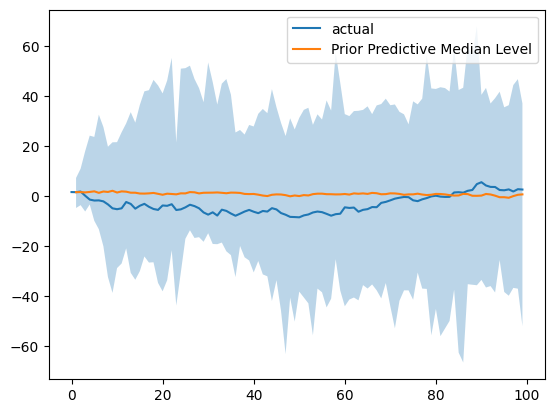

In [17]:
rng_key1, rng_key2 = random.split(prng_key)
# Prior Predictive
prior_predictive = Predictive(local_level, num_samples=100)
prior_predictive_samples = prior_predictive(rng_key2, locations)

prior_median_level = jnp.median(prior_predictive_samples['level'], axis=0)
hpdi_level = hpdi(prior_predictive_samples['level'])

# Plot the results
plt.plot(locations, label='actual')
plt.plot(jnp.arange(1, locations.shape[0]), prior_median_level, label='Prior Predictive Median Level')
plt.fill_between(jnp.arange(1, locations.shape[0]), hpdi_level[0, :], hpdi_level[1, :], alpha=0.3, interpolate=True)
plt.legend()

Posterior samples:

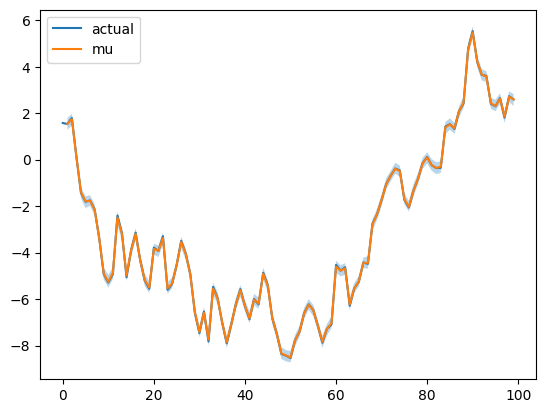

In [18]:
posterior_samples = mcmc.get_samples()

posterior_mu = posterior_samples['level']
posterior_mu_mean = posterior_mu.mean(axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)  # (2, 50)

plt.plot(locations, label='actual')
plt.plot(jnp.arange(1, locations.shape[0]), posterior_mu_mean, label='mu')
plt.fill_between(jnp.arange(1, locations.shape[0]), hpdi_mu[0, :], hpdi_mu[1, :], alpha=0.3, interpolate=True)
plt.legend()

In [48]:
# rng_key1, rng_key2 = random.split(prng_key)

# y = locations[:50]
# # Posterior Predictive
# posterior_predictive = Predictive(local_level, posterior_samples=posterior_samples)
# posterior_predictive_samples = posterior_predictive(rng_key2, y=y)

# # posterior_mean_mu = posterior_predictive_samples['mu'].mean(axis=0)
# posterior_mean_level = posterior_predictive_samples['y'].mean(axis=0)

# plt.plot(y, label='actual')
# plt.plot(jnp.arange(1, y.shape[0]), posterior_mean_level, label='y')
# plt.legend()

## Forecasting with the Local Level Model

So far, we've only been using this model to make inferences about the unknown parameters. But one of the more typical tasks in time series analysis is to produce useful forecasts or trends. 

We need to modify our local level model to perform a forecasting step. In the `numpyro` [time series examples](https://num.pyro.ai/en/stable/examples/holt_winters.html) we can see they solved this by adding a parameter called `future` which specifies the number of future periods.

In [70]:
# local level model

def local_level_future(y, future=0):
    T = y.shape[0]  # Used for the `future` logic in the transition function
    
    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    level_0 = numpyro.sample("init_level", dist.Normal(y[0], 1))

    def transition_fn(carry, t):
        level_t = carry
        new_level = jnp.where(
            t < T,
            numpyro.sample("level", dist.Normal(level_t, sigma_level)),
            level_t,
        )
        mu = level_t
        pred = numpyro.sample("pred", dist.Normal(mu, sigma_obs))
        return new_level, pred

    with numpyro.handlers.condition(data={"pred": y}):
        state, preds = scan(transition_fn, init=level_0, xs=jnp.arange(T+future))

    if future > 0:
        numpyro.deterministic('y_forecast', preds[-future:])

# numpyro.render_model(local_level_future, model_args=(locations, ), render_distributions=True)

We can then run inference just like before, but make sure that `future=0` or there will be an error. 

In [71]:
# Inference
mcmc = run_inference(local_level_future, prng_key, y=locations, future=0)
# mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1985.34it/s, 31 steps of size 9.71e-02. acc. prob=0.62]


We can now add the future periods with a `Predictive` call to forecast a few steps into the future

In [55]:
# forecast horizon
h = 10 

samples = mcmc.get_samples()

predictive = Predictive(local_level_future, samples, return_sites=["y_forecast", 'pred', 'level'])
preds = predictive(prng_key, y=locations, future=h)
mean_preds = preds['pred'].mean(axis=0)
hpdi_preds = hpdi(preds['pred'])

mean_level = preds['level'].mean(axis=0)
hpdi_level = hpdi(preds['level'])

mean_fcst = preds['y_forecast'].mean(axis=0)
hpdi_fcst = hpdi(preds['y_forecast'])

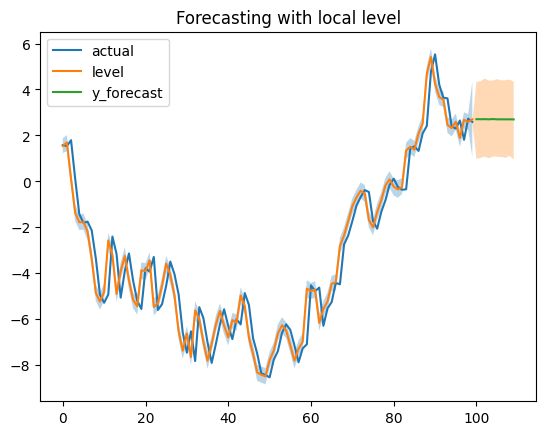

In [57]:
n = len(locations)
               
plt.plot(range(n), locations, label='actual')
plt.plot(range(n), mean_level[:-10], label='level')
plt.fill_between(range(n), hpdi_level[0,:-10], hpdi_level[1, :-10], alpha=0.3)
# plt.plot(range(n), mean_preds, label='forecast')
plt.plot(jnp.arange(n, n+10), mean_fcst, label='y_forecast')
# plt.fill_between(jnp.arange(n, n+10), hpdi_fcst[0,:], hpdi_fcst[1, :], alpha=0.3)
plt.fill_between(jnp.arange(0, n+10), hpdi_preds[0,:], hpdi_preds[1, :], alpha=0.3)
plt.title("Forecasting with local level")
plt.legend();

## Local Level model on Nile data

To test out this model on live data, we can use the nile river flow volume dataset that's easily available in `statsmodels`.

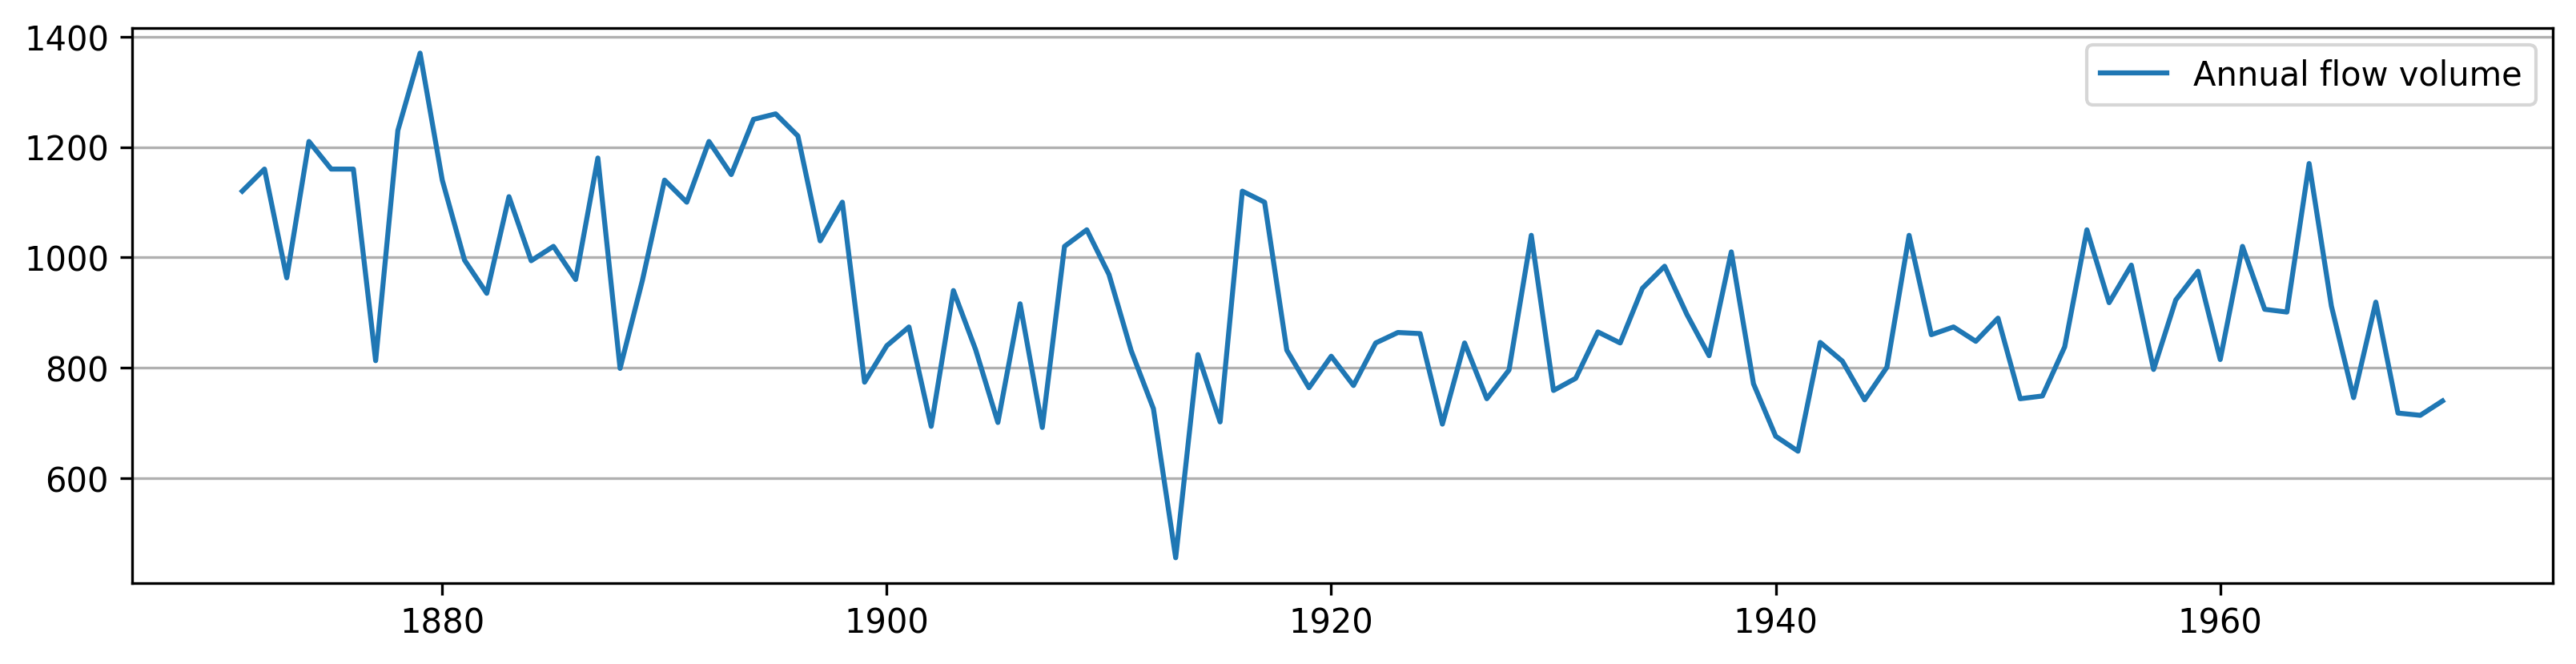

In [25]:
import statsmodels.api as sm
import pandas as pd

# This dataset is available in Statsmodels
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')

# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()
ax.yaxis.grid()

In [58]:
prng_key, rng_key = random.split(prng_key)

# Inference
mcmc = run_inference(local_level, prng_key, y=jnp.array(nile))
# mcmc.print_summary()

# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])
hpdi_level = hpdi(samples["level"])
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1733.36it/s, 15 steps of size 1.32e-01. acc. prob=0.85] 


Posterior Mean Sigma Level: 31.53086


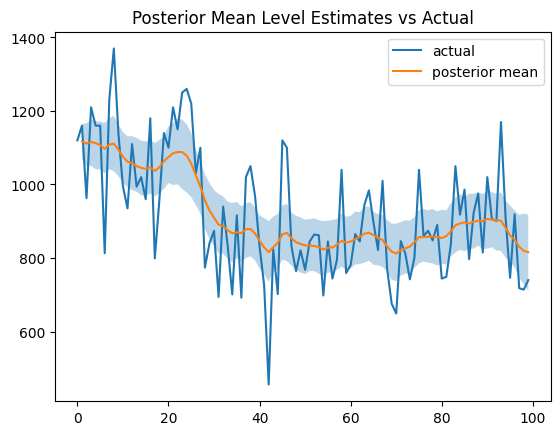

In [62]:
plt.plot(range(100), nile.values, label='actual')
plt.plot(jnp.arange(1, 100), posterior_mean_level, label='posterior mean')
plt.fill_between(jnp.arange(1, 100), hpdi_level[0, :], hpdi_level[1, :], alpha=0.3, interpolate=True)
plt.title('Posterior Mean Level Estimates vs Actual')
plt.legend();

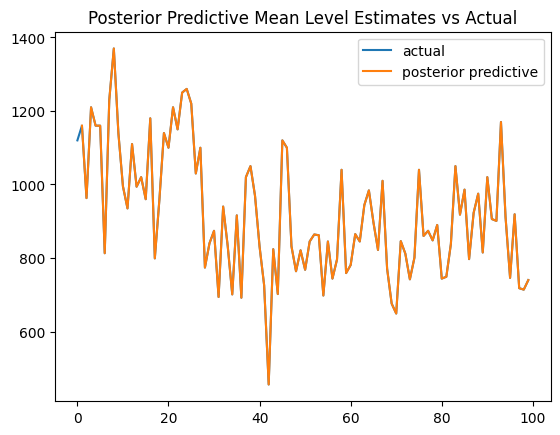

In [63]:
predictive = Predictive(local_level, samples)
preds = predictive(rng_key, y=jnp.array(nile.values))['y']
posterior_mean_y = jnp.mean(preds, axis=0)
hpdi_y = hpdi(preds)

plt.plot(range(100), nile.values, label='actual')
plt.plot(jnp.arange(1, 100), posterior_mean_y, label='posterior predictive')
plt.fill_between(jnp.arange(1, 100), hpdi_y[0, :], hpdi_y[1, :], alpha=0.3, interpolate=True)
plt.title('Posterior Predictive Mean Level Estimates vs Actual')
plt.legend();

## AR(2) Example

* [Example: AR2 process (numpyro docs)](https://num.pyro.ai/en/stable/examples/ar2.html#sphx-glr-download-examples-ar2-py)

Below I'll follow and document the AR2 example from the numpyro docs.

Given a univariate sequence of data:

$$
y_0, y_1, \dots, y_T
$$

We seek parameters $c$, $\alpha_1$, and $\alpha_2$ such that for each $t$ between $2$ and $T$, we have:

$$
y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$


We can restate this as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma)\\
\mu_t &= c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2}\\
c, \alpha_1, \alpha_2 &\sim \mathcal{N}(0,1)\\
\sigma &\sim \text{HalfNormal}(1)\\
\end{aligned}
$$

In [29]:
import numpyro 
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import arviz as az

def ar2_scan(y):
    """
    Bayesian autoregressive (AR) model of order 2
    """
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))  # lag 1 AR coef
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))  # lag 2 AR coef
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, _):
        y_prev, y_prev_prev = carry # now, carry is a tuple which we unpack
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, None

    timesteps = jnp.arange(y.shape[0] - 2)  # input into xs param in scan()
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        scan(f=transition, init=init, xs=timesteps)

Note that we added another effect handler `condition` which, in this case, is conditioning $y_t$ on observed values $y$, excluding the first two values (because it's an AR(2) model).

Next we'll test this model on simulated data

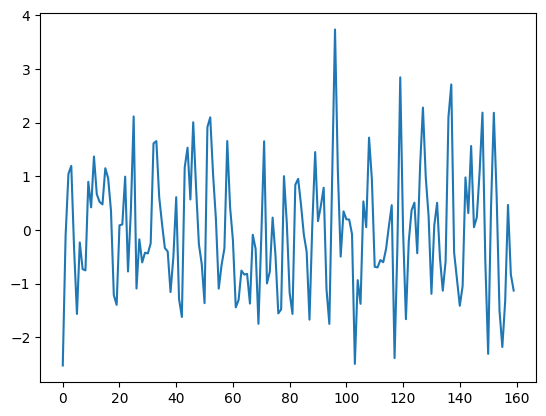

In [30]:
# Sim Data
from statsmodels.tsa.arima_process import ArmaProcess

# constants
num_data = 160

def sim_ar2_process(num_data):
    t = jnp.arange(0, num_data)

    # Generate an AR(2) model with true alpha_1=0.5, alpha_2=-0.4 and a constant.
    # Statsmodels `ArmaProcess` requires that we flip the signs in the input:
    ar_coef = jnp.array([1, -0.5, 0.4])
    ma_coef = jnp.array([1])
    arproc = ArmaProcess(ar_coef, ma_coef)

    # Generate the data and convert to a jax array
    y = arproc.generate_sample(num_data)
    y = jnp.array(y)
    return y

y = sim_ar2_process(num_data)
# look at the data real quick:
plt.plot(y);

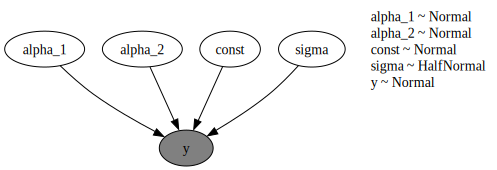

In [31]:
# Render the model so far
numpyro.render_model(ar2_scan, model_args=(y,), render_distributions=True)

In [32]:
# Inference

rng_key = random.PRNGKey(123)
sampler = NUTS(ar2_scan)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(rng_key, y=y)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1488.47it/s, 7 steps of size 7.52e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.42      0.08      0.41      0.29      0.54    839.07      1.00
   alpha_2     -0.38      0.07     -0.38     -0.51     -0.27    856.90      1.00
     const      0.00      0.08      0.00     -0.12      0.13    768.56      1.00
     sigma      1.02      0.06      1.02      0.93      1.12    924.58      1.00

Number of divergences: 0


Happily, we see that the model did a pretty good job at estimating the coefficients. 

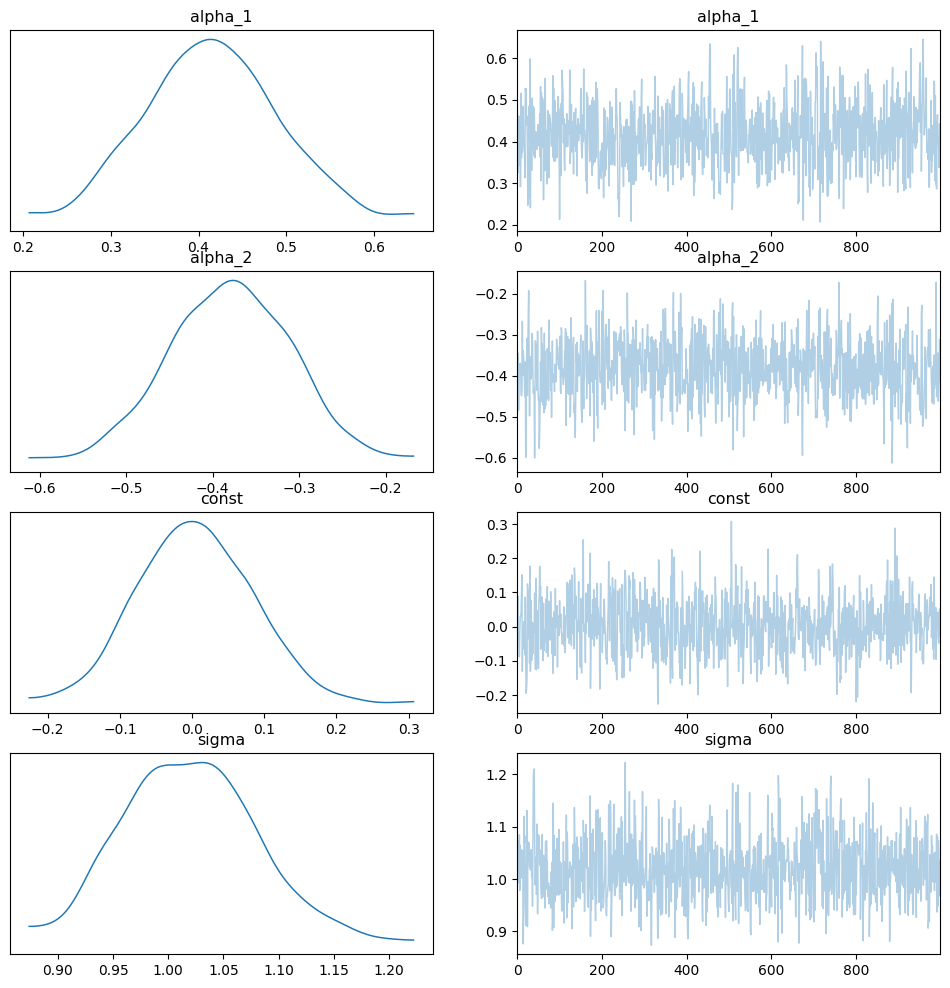

In [33]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)
# useful plot
az.plot_trace(data, compact=True, figsize=(12,12));

## Simple Exponential Smoothing

Adapted from https://num.pyro.ai/en/stable/examples/holt_winters.html

SES is:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\ell_t, \sigma_t)\\
\ell_t &= \alpha y_t + (1- \alpha)\ell_{t-1}
\end{aligned}
$$

Unlike the previous functions, there is a new `future` argument so that we can do some forecasts.

In [34]:
def ses(y, future=0):
    T = y.shape[0]
    alpha = numpyro.sample("alpha", dist.Beta(1, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level = carry
        level = jnp.where(
            t < T,
            alpha * (y[t]) + (1 - alpha) * (previous_level),
            previous_level,
        )
        mu = numpyro.deterministic('mu', previous_level)
        pred = numpyro.sample("pred", dist.Normal(mu, sigma))
        return level, pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(transition_fn, init=level_init, xs=jnp.arange(T + future))

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

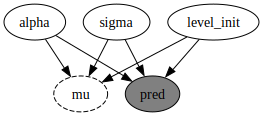

In [35]:
numpyro.render_model(ses, (jnp.array(nile), ))

In [36]:
# Inference
kernel = NUTS(ses)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, jnp.array(nile))

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1602.87it/s, 7 steps of size 7.66e-01. acc. prob=0.92]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha      0.67      0.02      0.67      0.63      0.70    990.42      1.01
  level_init      0.70      1.00      0.69     -0.97      2.26   1096.00      1.00
       sigma     43.20      0.49     43.20     42.41     43.97   1110.39      1.00

Number of divergences: 0


In [37]:
# Get posterior samples
samples = mcmc.get_samples()

In [38]:
predictive = Predictive(ses, samples, return_sites=["y_forecast", 'pred', 'mu'])
preds = predictive(rng_key, y=y, future=10)
mean_preds = preds['pred'].mean(axis=0)
hpdi_preds = hpdi(preds['pred'])

mean_fcst = preds['y_forecast'].mean(axis=0)
hpdi_fcst = hpdi(preds['y_forecast'])

Just like before we don't get past 1-step ahead predictions but we do get the final forecast:

In [39]:
mean_mu = preds['mu'].mean(axis=0)
hpdi_mu = hpdi(preds['mu'])

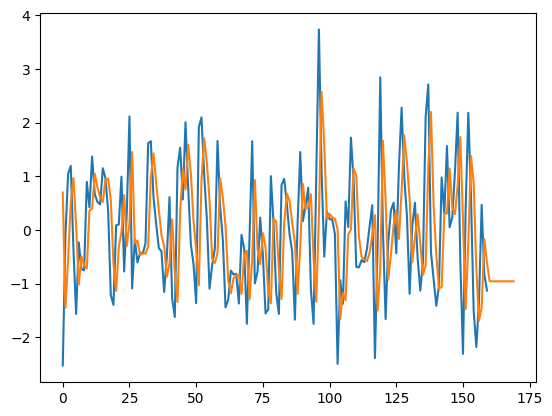

In [40]:
plt.plot(range(len(y)), y)
plt.plot(range(len(mean_mu)), mean_mu)

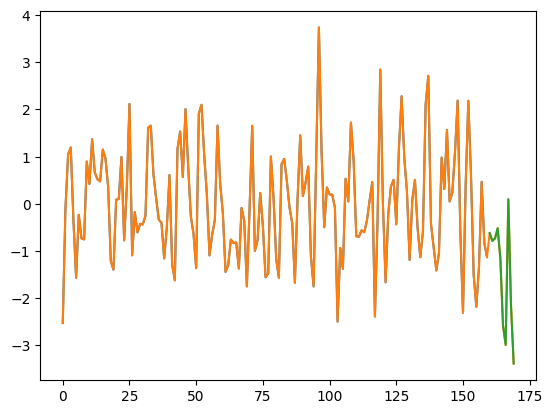

In [41]:
plt.plot(range(len(y)), y)
plt.plot(range(len(mean_preds)), mean_preds)
plt.plot(range(len(mean_preds))[-len(mean_fcst):], mean_fcst)

So I'll need to read a little more to figure out how to make this more worthwhile. So far this Bayesian model is useful to infer the hidden smoothing parameter $\alpha$ and noise $\sigma$ and to product a rudimentary forecast, but we'd need to add some extra bells and whistles so we can:

1. Evaluate the performance of this model using a 1-step ahead forecast on the past
2. Figure out how to do some of this stuff faster?
3. Take all the posterior possibilities of $\alpha$ and test how well that would have performed?

In [42]:
import numpy as np
res = np.zeros(len(y))
alpha = 0.67
for i in np.arange(1, len(y)-1):
    res[i] = (alpha * y[i] + (1-alpha) * res[i-1])

In [43]:
res = jnp.zeros(len(y))
alpha = 0.67
for i in np.arange(1, len(y)-1):
    res.at[i].set(alpha * y[i] + (1-alpha) * res[i-1])

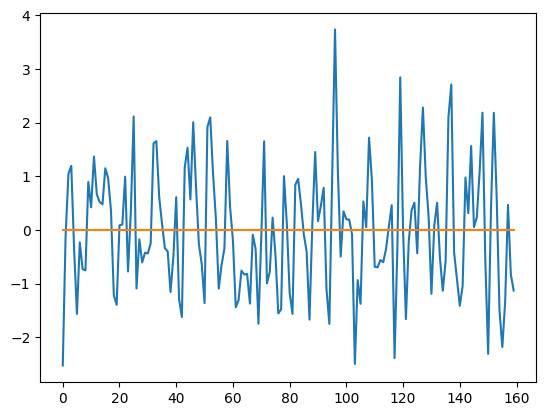

In [44]:
plt.plot(range(len(y)), y)
plt.plot(range(len(y)), res)

## Holt Winters

The full holt winters example


In [45]:
def holt_winters(y, n_seasons, future=0):
    T = y.shape[0]
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(1, 1))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)
    noise = numpyro.sample("noise", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))
    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry
        level = jnp.where(
            t < T,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )
        trend = jnp.where(
            t < T,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )
        new_season = jnp.where(
            t < T,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )
        step = jnp.where(t < T, 1, t - T + 1)
        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )
        return (level, trend, seasonality), pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(T + future),
        )

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])